In [1]:
%config IPCompleter.greedy=True

import itertools
import os, shutil
import pandas as pd
import time
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

import cv2
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
from PIL import Image
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

TF version: 2.3.1
Hub version: 0.7.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


In [110]:
##### Get Voc Training Dataset
voc_dir = r"D:\voc2012"

labels = ["person", "car", "bus", "bicycle", "motorbike","bird"]

data_trainval_all = pd.DataFrame(columns=["img_id"] + labels)

# Get Dataset and put it into a table
for i in range(len(labels)):
    data_trainval = pd.read_csv(voc_dir + '\ImageSets\Main\{}_trainval.txt'.format(labels[i]),header = None,index_col=False ,delim_whitespace=True, dtype={0:np.str, 1:np.int})
    
    if(i == 0):
        data_trainval_all['img_id'] = data_trainval[0]

    data_trainval_all[labels[i]] = data_trainval[1]

# get no. objects in dataset + delete rows with no relative objects
def remove_excluded_objects(data_trainval_all, labels):

    rows_to_del_trainval = []
    dataset_trainval_counter = {x:0 for x in labels}
    
    for i in range(len(data_trainval_all.index)):
        row = data_trainval_all.iloc[i]
        counter = 0
        for label in labels:

            if(row[label] == 1):
                dataset_trainval_counter[label] += 1
            elif(row[label] == -1):
                counter += 1

        if(counter == len(labels)):
            rows_to_del_trainval.append(row['img_id'])

    for img_id in rows_to_del_trainval:

        data_trainval_all.drop(data_trainval_all.loc[data_trainval_all['img_id'] == img_id].index, inplace=True)

            
    print(dataset_trainval_counter)

def number_of_objects(data_trainval_all, labels):
    
    dataset_trainval_counter = {x:0 for x in labels}
    
    for i in range(len(data_trainval_all.index)):
        row = data_trainval_all.iloc[i]

        for label in labels:

            if(row[label] == 1):
                dataset_trainval_counter[label] += 1
            
    print(dataset_trainval_counter)

# delete rows with people to reduce bias
def decrease_class_amount(data_trainval_all, object_name, delete_amount, labels):
    rows_to_del_trainval = []

    data_trainval_object = data_trainval_all.loc[data_trainval_all[object_name] == 1]
    how_many_ofobject_to_delete = delete_amount
    deleted_object = 0
    
    for i in range(len(data_trainval_object)):
        
        if(deleted_object == how_many_ofobject_to_delete):
            break
        
        row = data_trainval_object.iloc[i]
        rows_to_del_trainval.append(row['img_id'])
        deleted_object += 1

    for img_id in rows_to_del_trainval:

        data_trainval_all.drop(data_trainval_all.loc[data_trainval_all['img_id'] == img_id].index, inplace=True)

remove_excluded_objects(data_trainval_all,labels)
# number_of_objects(data_trainval_all,labels)

# Delete X amount of samples per label in order to even out the distribution
decrease_class_amount(data_trainval_all, "person", 3500, labels)
number_of_objects(data_trainval_all,labels)
decrease_class_amount(data_trainval_all, "car", 500, labels)
number_of_objects(data_trainval_all,labels)
decrease_class_amount(data_trainval_all, "bird", 450, labels)
number_of_objects(data_trainval_all,labels)


# make dataset a 80/20 split

train_size = int(len(data_trainval_all.index)*0.8)
val_size = len(data_trainval_all.index) - train_size

data_train_all = data_trainval_all.iloc[:train_size]
data_val_all = data_trainval_all.iloc[train_size:]


{'person': 4087, 'car': 1161, 'bus': 421, 'bicycle': 552, 'motorbike': 526, 'bird': 765}
{'person': 587, 'car': 788, 'bus': 272, 'bicycle': 301, 'motorbike': 275, 'bird': 745}
{'person': 587, 'car': 288, 'bus': 216, 'bicycle': 286, 'motorbike': 248, 'bird': 743}
{'person': 587, 'car': 288, 'bus': 216, 'bicycle': 286, 'motorbike': 248, 'bird': 293}


In [111]:
# Make a script to seperate data into subfolders

for label in labels:
    try:
        os.makedirs(voc_dir + r"\voc_submodules_train\{}".format(label))
    except FileExistsError:
        pass
    
    try:
        os.makedirs(voc_dir + r"\voc_submodules_val\{}".format(label))
    except FileExistsError:
        pass

    
for i, row in data_train_all.iterrows():
    for label in labels:
        if(row[label] == 1):
            shutil.copyfile(voc_dir + r'\JPEGImages\{}.jpg'.format(row['img_id']), 
                            voc_dir + r'\voc_submodules_train\{}\{}.jpg'.format(label, row['img_id']) )
            
for i, row in data_val_all.iterrows():
    for label in labels:
        if(row[label] == 1):
            shutil.copyfile(voc_dir + r'\JPEGImages\{}.jpg'.format(row['img_id']), 
                            voc_dir + r'\voc_submodules_val\{}\{}.jpg'.format(label, row['img_id']) )

print("Finished Splitting Subfolders")


Finished Splitting Subfolders


In [112]:
train_data_dir =voc_dir + r'\voc_submodules_train\\'
test_data_dir = voc_dir + r'\voc_submodules_val\\'
#try diff scale hyper params

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=40.,
#         width_shift_range = 0.2,
#         height_shift_range = 0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
#         shuffle = True,
        target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

val_generator = train_datagen.flow_from_directory(
        test_data_dir,
#         shuffle = True,
        target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 1521 images belonging to 6 classes.
Found 460 images belonging to 6 classes.


In [113]:
###### MobilenetV2
# classifier_model = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
# classifier_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

###### Efficientnet b0 -> for 224x224 images
# classifier_model = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
# classifier_model = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"
classifier_model = "https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2"

###### Resnet v50
# classifier_model = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"



model = tf.keras.Sequential([
    # input layer already specified in classifier
    tf.keras.layers.InputLayer(input_shape=IMAGE_SHAPE + (3,)),
    tf.keras.layers.experimental.preprocessing.Rescaling( scale = 1./255),
    tf.keras.layers.experimental.preprocessing.Normalization(),
    hub.KerasLayer(classifier_model, trainable=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, 
                          kernel_regularizer=tf.keras.regularizers.l2(0.0005),
                          activation='softmax')

])

model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_18 (Rescaling)     (None, 224, 224, 3)       0         
_________________________________________________________________
normalization_16 (Normalizat (None, 224, 224, 3)       7         
_________________________________________________________________
keras_layer_22 (KerasLayer)  (None, 1280)              3413024   
_________________________________________________________________
dropout_22 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 6)                 7686      
Total params: 3,420,717
Trainable params: 7,686
Non-trainable params: 3,413,031
_________________________________________________________________


In [114]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr = 0.001),
#     optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [115]:
# go for a 3:4:5 learning rate when retraining. e.g ~ 10^-3/10^-4... etc

def scheduler(epoch):
    print("epoch: {} | current lr: {}".format(epoch,tf.keras.backend.eval(model.optimizer.lr)))
    
    if epoch == 10:
        model.optimizer.lr = 0.00001
    if epoch == 30:
        model.optimizer.lr = 0.000001
    return tf.keras.backend.eval(model.optimizer.lr)

change_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

history = model.fit(train_generator, 
                    epochs=15,
                    validation_data= val_generator,
                    callbacks=[change_lr])

epoch: 0 | current lr: 0.0010000000474974513
Epoch 1/15
48/48 [==============================] - 37s 761ms/step - loss: 1.5726 - accuracy: 0.5431 - val_loss: 1.4575 - val_accuracy: 0.6543
epoch: 1 | current lr: 0.0010000000474974513
Epoch 2/15
48/48 [==============================] - 26s 534ms/step - loss: 1.3335 - accuracy: 0.7778 - val_loss: 1.3995 - val_accuracy: 0.6870
epoch: 2 | current lr: 0.0010000000474974513
Epoch 3/15
48/48 [==============================] - 26s 540ms/step - loss: 1.2816 - accuracy: 0.8100 - val_loss: 1.3973 - val_accuracy: 0.6826
epoch: 3 | current lr: 0.0010000000474974513
Epoch 4/15
48/48 [==============================] - 26s 548ms/step - loss: 1.2665 - accuracy: 0.8113 - val_loss: 1.3783 - val_accuracy: 0.6957
epoch: 4 | current lr: 0.0010000000474974513
Epoch 5/15
48/48 [==============================] - 26s 551ms/step - loss: 1.2556 - accuracy: 0.8231 - val_loss: 1.3797 - val_accuracy: 0.6870
epoch: 5 | current lr: 0.0010000000474974513
Epoch 6/15
48/4

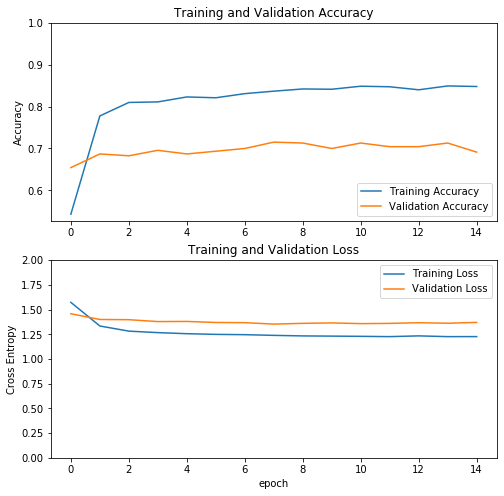

In [116]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


fig = plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [100]:
t = time.time()

# model_name = "mobilenetV2"
model_name = "efficientnet"

export_path = r"tmp\saved_models\{}_valacc{}perc_{}".format(int(t),int((val_acc[-1])*100),model_name)
model.save(export_path)
fig.savefig(export_path  + "\plot.png")


INFO:tensorflow:Assets written to: tmp\saved_models\1605230894_valacc65perc_efficientnet\assets


INFO:tensorflow:Assets written to: tmp\saved_models\1605230894_valacc65perc_efficientnet\assets
